# Speaker Change Detection

Speaker change detection is an important part of speaker diarization systems. It aims at finding the boundaries between speech turns of two different speakers.

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/speaker-change](https://github.com/huseinzol05/malaya-speech/tree/master/example/speaker-change).
    
</div>

<div class="alert alert-info">

This module is language independent, so it save to use on different languages. Pretrained models trained on multilanguages.
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

### Dataset

Trained on Voxceleb V1 and LibriSpeech datasets with augmented noise.

In [1]:
import malaya_speech
import numpy as np
from malaya_speech import Pipeline

In [2]:
y, sr = malaya_speech.load('speech/video/The-Singaporean-White-Boy.wav')
len(y), sr

(1634237, 16000)

In [3]:
# just going to take 30 seconds
y = y[:sr * 30]

In [4]:
import IPython.display as ipd
ipd.Audio(y, rate = sr)

This audio extracted from https://www.youtube.com/watch?v=HylaY5e1awo&t=2s

### Why need to detect speaker change

Let say you have VAD model, like below,

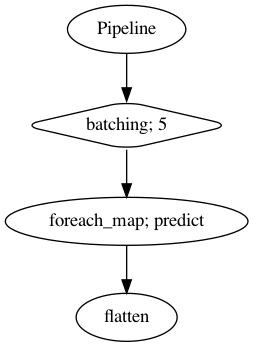

In [5]:
vad = malaya_speech.vad.deep_model(model = 'vggvox-v2')
frames = list(malaya_speech.utils.generator.frames(y, 30, sr))
p = Pipeline()
pipeline = (
    p.batching(5)
    .foreach_map(vad.predict)
    .flatten()
)
p.visualize()

In [6]:
result = p.emit(frames)
result.keys()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=480
  n_fft, y.shape[-1]


dict_keys(['batching', 'predict', 'flatten'])

In [7]:
frames_vad = [(frame, result['flatten'][no]) for no, frame in enumerate(frames)]
grouped_vad = malaya_speech.utils.group.group_frames(frames_vad)
grouped_vad = malaya_speech.utils.group.group_frames_threshold(grouped_vad, threshold_to_stop = 0.3)
grouped_vad = malaya_speech.utils.group.group_frames(grouped_vad)

In [8]:
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr)

<Figure size 1500x300 with 1 Axes>

As you can see, sometime in one voice activity can have multiple speakers, example, speaker B continue to speak after speaker A, so this will detected as one voice activity. So to cut that one voice activity into N voice activity, we can use speaker change detection!

### List available deep model

In [9]:
malaya_speech.speaker_change.available_model()

INFO:root:last accuracy during training session before early stopping.


,Size (MB),Quantized Size (MB),Accuracy
vggvox-v2,31.1,7.92,0.63979
speakernet,20.3,5.18,0.64524


### Load deep model

```python
def deep_model(model: str = 'speakernet', quantized: bool = False, **kwargs):
    """
    Load speaker change deep model.

    Parameters
    ----------
    model : str, optional (default='vggvox-v2')
        Model architecture supported. Allowed values:

        * ``'vggvox-v2'`` - finetuned VGGVox V2.
        * ``'speakernet'`` - finetuned SpeakerNet.
    quantized : bool, optional (default=False)
        if True, will load 8-bit quantized model. 
        Quantized model not necessary faster, totally depends on the machine.

    Returns
    -------
    result : malaya_speech.supervised.classification.load function
    """
```

In [10]:
speakernet = malaya_speech.speaker_change.deep_model('speakernet')
vggvox_v2 = malaya_speech.speaker_change.deep_model('vggvox-v2')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


### How to use Speaker Change detection

We trained speaker change detection models on 500 ms frames, so, split a sample into multiple chunks with length 500 ms each, and speaker change only got 2 classes, False and True.

In [11]:
frames = list(malaya_speech.utils.generator.frames(y, 500, sr))

In [12]:
%%time

probs_vggvox_v2 = [(frame, vggvox_v2.predict_proba([frame])[0, 1]) for frame in frames]

CPU times: user 13.6 s, sys: 2.25 s, total: 15.9 s
Wall time: 3.27 s


In [13]:
%%time

probs_speakernet = [(frame, speakernet.predict_proba([frame])[0, 1]) for frame in frames]

CPU times: user 5.78 s, sys: 646 ms, total: 6.42 s
Wall time: 1.19 s


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

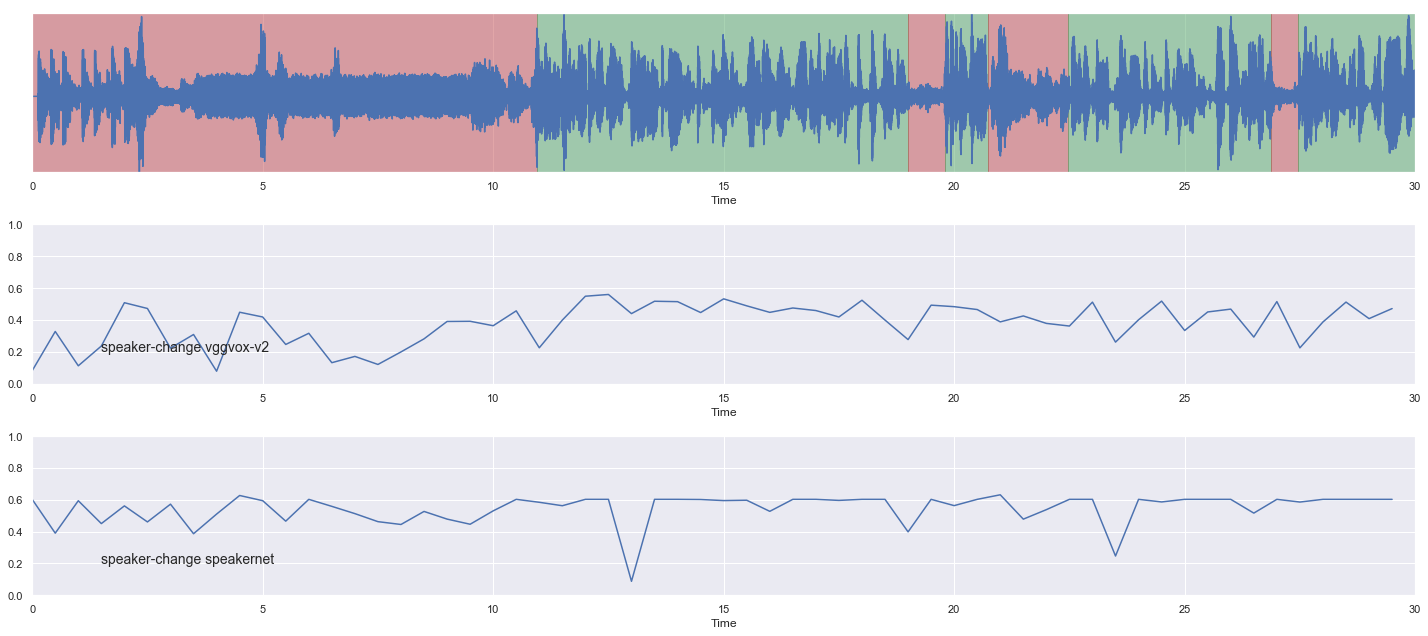

In [15]:
nrows = 3
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(probs_vggvox_v2, 'speaker-change vggvox-v2', yaxis = True,
                                                     ax = ax[1])
malaya_speech.extra.visualization.plot_classification(probs_speakernet, 'speaker-change speakernet', yaxis = True,
                                                     ax = ax[2])
fig.tight_layout()
plt.show()

### Split VAD results into smaller samples

In order to split one VAD result into multiple samples based on speaker change detection, just use `malaya_speech.speaker_change.split_activities`,

```python
def split_activities(
    vad_results,
    speaker_change_results,
    speaker_change_threshold: float = 0.5,
    sr: int = 16000,
    ignore_not_activity = True,
):
    """
    split VAD based on speaker change threshold, worse-case O(N^2).

    Parameters
    ----------
    vad_results: List[Tuple[Frame, label]]
        results from VAD.
    speaker_change_results: List[Tuple[Frame, float]], optional (default=None)
        results from speaker change module, must in float result.
    speaker_change_threshold: float, optional (default=0.5)
        in one voice activity sample can be more than one speaker, split it using this threshold.
    sr: int, optional (default=16000)
        sample rate, classification model in malaya-speech use 16k.
    ignore_not_activity: bool, optional (default=True)
        If True, will ignore if result VAD is False, else will try to split.

    Returns
    -------
    result : List[Tuple[Frame, label]]
    """
```

In [16]:
splitted_vggvox_v2 = malaya_speech.speaker_change.split_activities(grouped_vad, probs_vggvox_v2)
splitted_speakernet = malaya_speech.speaker_change.split_activities(grouped_vad, probs_speakernet)

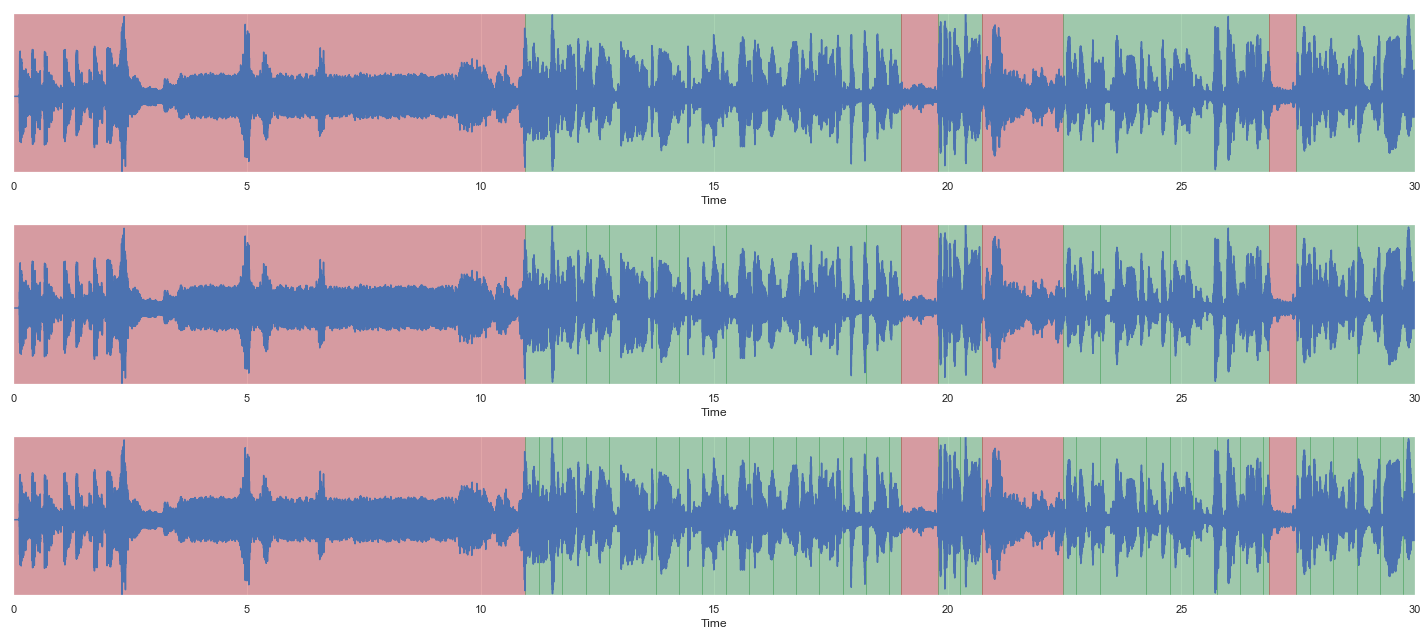

In [17]:
nrows = 3
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.visualize_vad(y, splitted_vggvox_v2, sr, ax = ax[1])
malaya_speech.extra.visualization.visualize_vad(y, splitted_speakernet, sr, ax = ax[2])
fig.tight_layout()
plt.show()

You can see thin vertical lines for second and third graphs more than first graph.

### Load Quantized deep model

To load 8-bit quantized model, simply pass `quantized = True`, default is `False`.

We can expect slightly accuracy drop from quantized model, and not necessary faster than normal 32-bit float model, totally depends on machine.

In [18]:
quantized_vggvox_v2 = malaya_speech.speaker_change.deep_model(model = 'vggvox-v2', quantized = True)

In [19]:
%%time

probs_vggvox_v2 = [(frame, vggvox_v2.predict_proba([frame])[0, 1]) for frame in frames]

CPU times: user 13.9 s, sys: 2.49 s, total: 16.4 s
Wall time: 3.42 s


In [20]:
%%time

probs_quantized_vggvox_v2 = [(frame, quantized_vggvox_v2.predict_proba([frame])[0, 1]) for frame in frames]

CPU times: user 14.2 s, sys: 2.65 s, total: 16.9 s
Wall time: 3.64 s


In [21]:
splitted_vggvox_v2 = malaya_speech.speaker_change.split_activities(grouped_vad, probs_vggvox_v2)
splitted_probs_quantized_vggvox_v2 = malaya_speech.speaker_change.split_activities(grouped_vad, 
                                                                                   probs_quantized_vggvox_v2)

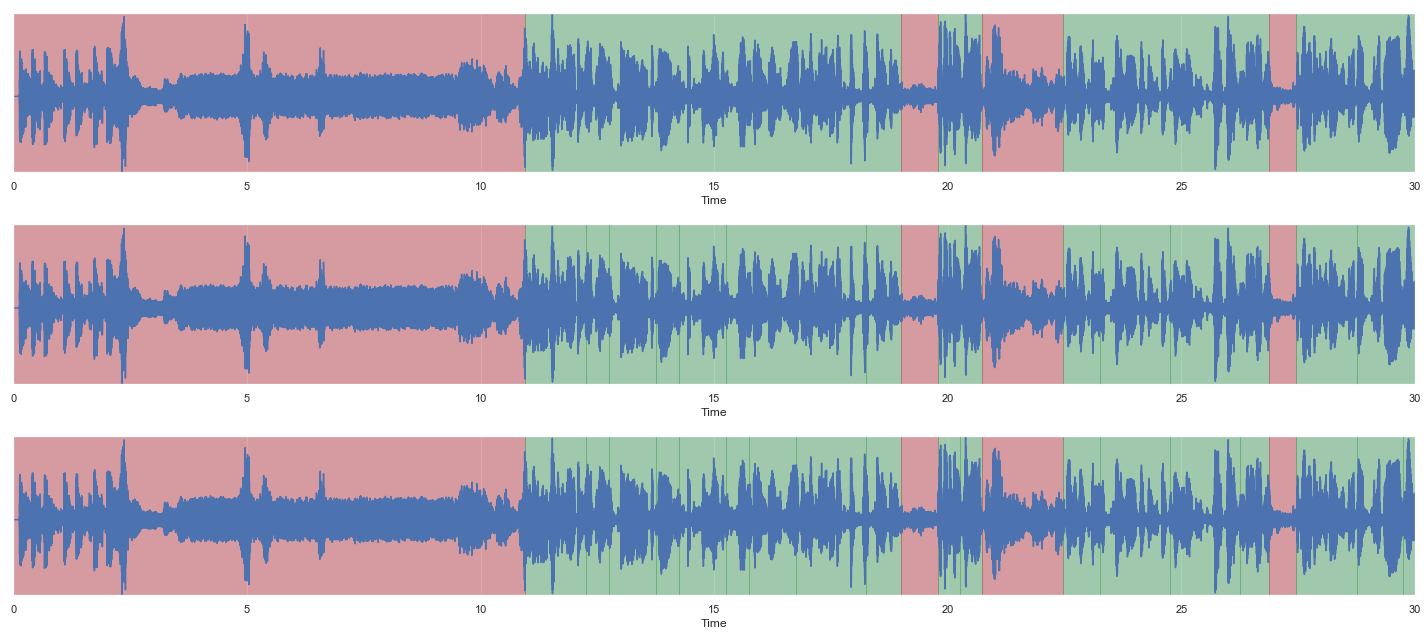

In [22]:
nrows = 3
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.visualize_vad(y, splitted_vggvox_v2, sr, ax = ax[1])
malaya_speech.extra.visualization.visualize_vad(y, splitted_probs_quantized_vggvox_v2, sr, ax = ax[2])
fig.tight_layout()
plt.show()

### Reference

1. The Singaporean White Boy - The Shan and Rozz Show: EP7, https://www.youtube.com/watch?v=HylaY5e1awo&t=2s&ab_channel=Clicknetwork